In [1]:
import tweepy #tweepy is a python library that can be used to access Twitter API
import pandas as pd #for data manipulation and analysis

In [13]:
import re 
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
nltk.download('punkt')   
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from textblob import TextBlob

[nltk_data] Downloading package punkt to C:\Users\Accidental
[nltk_data]     G\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Accidental
[nltk_data]     G\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# token is a bearer token provided on twitter developer's portal
token = ''

# for authentication, tweepy client needs a bearer token
client = tweepy.Client(bearer_token = token)

'''
# Defining a query to retrieve data from twitter
# The query retrieves tweets with the phrase Ukraine war or Russia
# The tweets retrieved are written in english
'''
query = '(oscars2022 OR willsmith OR slapchrisrock OR willsmithassault OR chrisrock) lang:en -is:retweet has:media'

start = '2022-04-06T06:00:00Z'

end = '2022-04-09T09:00:00Z'

tweet_fields = ['attachments', 'text', 'author_id', 'conversation_id', 'created_at', 'entities', 'id',
          'in_reply_to_user_id', 'lang', 'possibly_sensitive', 'referenced_tweets', 'reply_settings', 'source']

user_fields = ['id','name', 'username', 'profile_image_url', 'public_metrics']

media_fields = ['media_key', 'type', 'url', 'preview_image_url', 'public_metrics']

expansions = ['author_id', 'attachments.media_keys']

tweets = client.search_recent_tweets(query=query, end_time = end, tweet_fields= tweet_fields, media_fields = media_fields, 
                                     user_fields = user_fields, expansions = expansions, start_time = start, 
                                     max_results = 100)



In [5]:
columns = ['id', 'attachments', 'text', 'author_id', 'conversation_id', 'created_at', 'entities',
          'in_reply_to_user_id', 'lang', 'possibly_sensitive', 'referenced_tweets', 'reply_settings', 'source']
data = []
for tweet in tweets.data:
    data.append([tweet.id, tweet.attachments, tweet.text, tweet.author_id, tweet.conversation_id, tweet.created_at,
                 tweet.entities, tweet.in_reply_to_user_id, tweet.lang, tweet.possibly_sensitive, 
                 tweet.referenced_tweets, tweet.reply_settings, tweet.source])
    
df = pd.DataFrame(data, columns = columns)
df.to_csv('celebrity.csv')
df.head()

,id,attachments,text,author_id,conversation_id,created_at,entities,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,source
0,1512716920658833411,{'media_keys': ['7_1512716898814906373']},Will Smith being tossed out of Chris Rock’s ho...,936240748017709057,1512716920658833411,2022-04-09 08:59:53+00:00,"{'urls': [{'start': 155, 'end': 178, 'url': 'h...",NaN,en,False,None,everyone,Twitter for iPhone
1,1512716801041477634,{'media_keys': ['3_1512716793365811206']},You will eventually feel better...🤗 #ChrisRock...,61608747,1512716801041477634,2022-04-09 08:59:24+00:00,"{'urls': [{'start': 61, 'end': 84, 'url': 'htt...",NaN,en,False,None,everyone,The Social Jukebox
2,1512716372169666561,{'media_keys': ['3_1512681094864596994']},Will Smith responds to Academy's 10-year ban a...,1479704829224095746,1512716372169666561,2022-04-09 08:57:42+00:00,"{'urls': [{'start': 156, 'end': 179, 'url': 'h...",NaN,en,False,None,everyone,Twitter for Android
3,1512716235770839041,{'media_keys': ['3_1512714755974348810']},A lot of guys love unconditionally. Some women...,970413582,1512716235770839041,2022-04-09 08:57:10+00:00,"{'urls': [{'start': 278, 'end': 301, 'url': 'h...",NaN,en,False,None,everyone,Twitter Web App
4,1512715758698127360,{'media_keys': ['3_1512715756345217029']},"I was born in a war zone, but this is definite...",1084247078774231041,1512715758698127360,2022-04-09 08:55:16+00:00,"{'urls': [{'start': 123, 'end': 146, 'url': 'h...",NaN,en,False,None,everyone,Twitter for Android


In [6]:
print(tweets.meta)

{'newest_id': '1512716920658833411', 'oldest_id': '1512682091355394051', 'result_count': 100, 'next_token': 'b26v89c19zqg8o3fpytlv6cf9o2tgpyf4ra4p7nmxv4hp'}


In [7]:
print(tweets.meta['result_count'])

100


In [14]:
# Preprocessing
# removing stopwords, punctuations, @mentions, links
def cleanText(text):
  text = text.lower()
  # Removes all mentions (@username) from the tweet since it is of no use to us
  text = re.sub(r'(@[A-Za-z0-9_]+)', '', text)
    
  # Removes any link in the text
  text = re.sub('http://\S+|https://\S+', '', text)

  # Only considers the part of the string with char between a to z or digits and whitespace characters
  # Basically removes punctuation
  text = re.sub(r'[^\w\s]', '', text)

  # Removes stop words that have no use in sentiment analysis 
  text_tokens = word_tokenize(text)
  text = [word for word in text_tokens if not word in stopwords.words()]

  text = ' '.join(text)
  return text

In [15]:
def stem(text):
  # This function is used to stem the given sentence
  porter = PorterStemmer()
  token_words = word_tokenize(text)
  stem_sentence = []
  for word in token_words:
    stem_sentence.append(porter.stem(word))
  return " ".join(stem_sentence)

In [16]:
def sentiment(cleaned_text):
  # Returns the sentiment based on the polarity of the input TextBlob object
  if cleaned_text.sentiment.polarity > 0:
    return 'positive'
  elif cleaned_text.sentiment.polarity < 0:
    return 'negative'
  else:
    return 'neutral'

In [17]:
def perform_sent(data):
    tweet_data_purified = []
    for tweet in data:
        txt = tweet.text
        clean_txt = cleanText(txt) # Cleans the tweet
        stem_txt = TextBlob(stem(clean_txt)) # Stems the tweet
        sent = sentiment(stem_txt) # Gets the sentiment from the tweet
        tweet_data_purified.append((txt, clean_txt, sent))
        
    return tweet_data_purified

In [18]:
new_dict = perform_sent(tweets.data)
print(new_dict[0])

('Will Smith being tossed out of Chris Rock’s house after trying to apologize. #JadaPinkettSmith #WillSmithAssault #willsmithchrisrock #WilllSmith #FYP #fun https://t.co/B8Byo8DbRU', 'smith tossed chris rocks house trying apologize jadapinkettsmith willsmithassault willsmithchrisrock willlsmith fyp fun', 'positive')


In [19]:
cols = ['original_text', 'cleaned_text', 'classification']
df_sent = pd.DataFrame(new_dict, columns = cols)
df_sent.head()

,original_text,cleaned_text,classification
0,Will Smith being tossed out of Chris Rock’s ho...,smith tossed chris rocks house trying apologiz...,positive
1,You will eventually feel better...🤗 #ChrisRock...,eventually feel better chrisrock positivity,positive
2,Will Smith responds to Academy's 10-year ban a...,smith responds academys 10year ban 2022 oscars...,neutral
3,A lot of guys love unconditionally. Some women...,lot guys love unconditionally women advantage ...,positive
4,"I was born in a war zone, but this is definite...",born zone definitely traumatic sorry white beh...,neutral


In [20]:
ptweets = df_sent[df_sent['classification'] == 'positive']
p_perc = 100 * len(ptweets)/len(df_sent)
ntweets = df_sent[df_sent['classification'] == 'negative']
n_perc = 100 * len(ntweets)/len(df_sent)
print(f'Positive tweets {p_perc} %')
print(f'Neutral tweets {100 - p_perc - n_perc} %')
print(f'Negative tweets {n_perc} %')

Positive tweets 23.0 %
Neutral tweets 70.0 %
Negative tweets 7.0 %


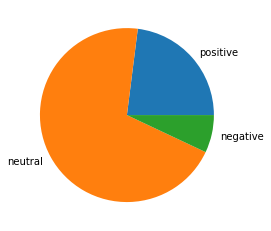

In [24]:
dict_sent = {"positive": p_perc, "neutral": 100 - p_perc - n_perc, "negative": n_perc}
plt.pie(dict_sent.values(), labels = dict_sent.keys())
plt.show()

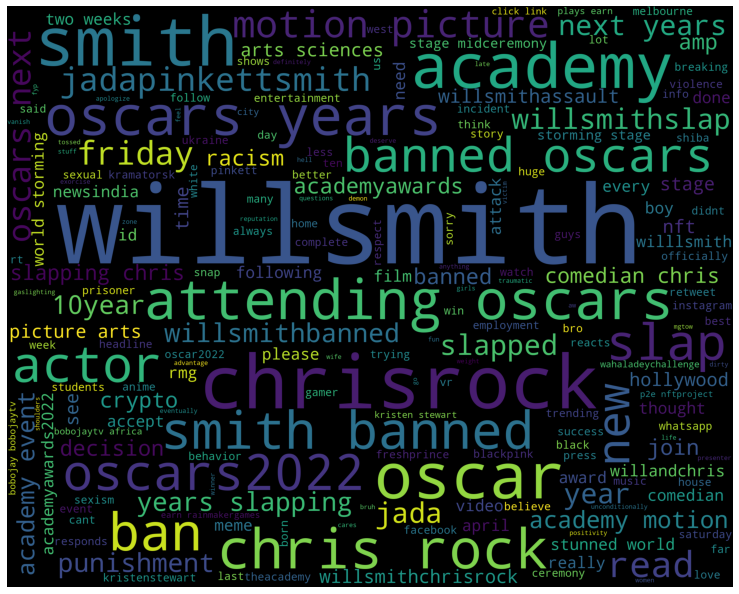

In [21]:
twt = " ".join(df_sent['cleaned_text'])
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', width=2500, height=2000).generate(twt)

plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()